##### Imports & Global Variables

In [2]:
# %pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

from regime_detection import KAMA
from regime_detection import MarkovSwitchingModel

In [4]:
sdte = datetime(1990, 1, 1)
edte = datetime(2018, 1, 1)

# Getting Data

In [5]:
symbol_name_dict = pd.read_csv('data/inputs/fmp_index_list.csv').set_index('symbol')['name'].to_dict()
index_data = pd.read_csv('data/processed/index_data.csv', index_col=0, header=[0, 1], parse_dates=True)

index_close_cols = index_data.columns[index_data.columns.get_level_values(1) == 'close']
index_close_prices = index_data[index_close_cols].droplevel(1, axis=1).rename(columns=symbol_name_dict)

sp500_prices = index_close_prices['S&P 500'].dropna()

In [6]:
# index_close_prices.apply(lambda col: col.dropna().index[0])

# Testing KAMA

In [7]:
kama = KAMA(n=10, n_fast=2, n_slow=30)
sp500_kama = kama.calculate_kama(sp500_prices)
# pd.concat([sp500_prices, sp500_kama[0], sp500_kama[1], sp500_kama[2]], axis=1).head(11)

px.line(pd.concat([sp500_prices, sp500_kama[0]], axis=1).tail(252*5))

# Testing MSR

In [ ]:
sdte = datetime(1990, 1, 1)
edte = datetime(2018, 1, 1)
# edte = sp500_prices.index[-1]
sp500_log_returns = np.log(sp500_prices.loc[sdte:edte]).diff().dropna()
sp500_log_returns = pd.DataFrame({'returns': sp500_log_returns})

model = MarkovSwitchingModel(n_regimes=3)
model.set_priors(
    mean_prior_mean=0.0,
    mean_prior_var=0.01,
    beta_prior_mean=0.0,
    beta_prior_var=0.3,
    sigma_prior_shape=3.0,
    sigma_prior_scale=0.0001,
    transition_prior_alpha=8.0
)
# Fit the model
print("Fitting Markov Switching Model on S&P 500 data...")
model.fit(sp500_log_returns['returns'], n_samples=200, burnin=75, verbose=True)

# Run comprehensive analysis
regime_probs = model.analyze_results(sp500_log_returns, data_name="S&P 500")

# Detailed regime characteristics
regime_classification = model.regime_characteristics(sp500_log_returns, regime_probs, data_name="S&P 500")

# Model diagnostics
model.diagnostics(sp500_log_returns, regime_probs, data_name="S&P 500", trace_plots=False)

print("\n" + "="*70)
print("TESTING COMPLETE!")
print("="*70)

Fitting Markov Switching Model on S&P 500 data...
Running Gibbs sampler: 275 total iterations
Burnin: 75, Samples: 200, Thin: 1
Iteration 25/275


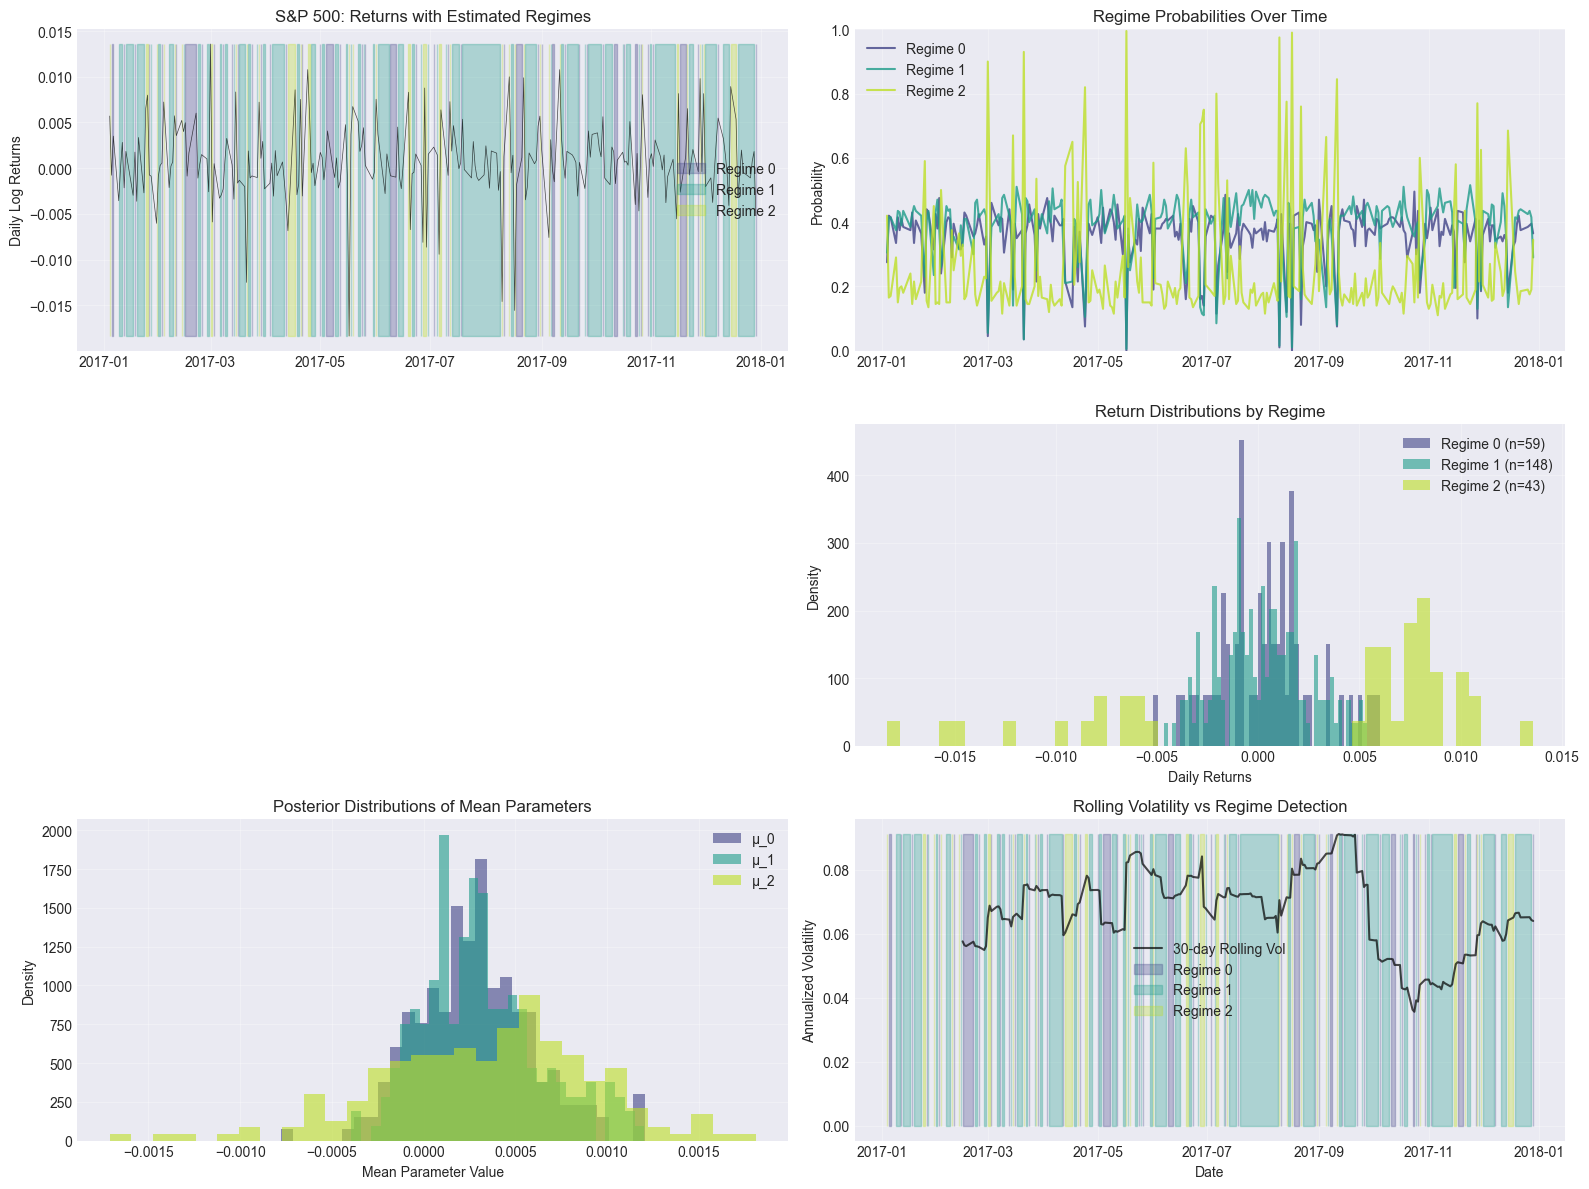

In [ ]:
# Create visualizations
model.plot_results(sp500_log_returns, regime_probs, data_name="S&P 500")

# Next Section